<a href="https://colab.research.google.com/github/scope-lab-vu/transactive-blockchain/blob/master/TCPS_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To make this notebook work in Colab, the following must be done:

  1. The Cplex binary installer needs to be uploaded to your Google Drive in a directory named 'ColabLibraries'
  2. Prosumer offer data should be uploaded into a directory named 'profiles'

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
from getpass import getpass
import os

Mount Google Drive to access installation files

In [430]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Install cplex from Google Drive. installer.properties included in directory for silent install

In [431]:
! chmod u+x /content/gdrive/My\ Drive/ColabLibraries/cplex_studio129.linux-x86-64.bin

!/content/gdrive/My\ Drive/ColabLibraries/cplex_studio129.linux-x86-64.bin -f "installer.properties"


Preparing to install
Extracting the JRE from the installer archive...
Unpacking the JRE...
Extracting the installation resources from the installer archive...
Configuring the installer for this system's environment...

Launching installer...



Install cplex python binaries

In [0]:
%%capture
! cd /opt/ibm/ILOG/CPLEX_Studio129/python/; python3 setup.py install;

Clone transax repo

In [433]:
user = getpass('GitHub User')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/scope-lab-vu/transactive-blockchain.git


GitHub User··········
GitHub password··········
fatal: destination path 'transactive-blockchain' already exists and is not an empty directory.


Install transax library

In [0]:
%%capture
! cd /content/transactive-blockchain/transax; sudo pip3 install .

Set up the microgrid and the solver

In [0]:
import cplex
from transax.Microgrid import Microgrid
from transax.MatchingSolver import Offer, MatchingSolver
microgrid = Microgrid(interval_length=1.0, C_ext=25000, C_int=250000, feeders=[0], prosumer_feeder={
    101: 0,
    102: 0,
    103: 0,
    104: 0,
    105: 0,
    201: 0,
    202: 0,
    203: 0,
    204: 0,
    207: 0,
    301: 0,
    302: 0,
    303: 0,
    304: 0,
    305: 0,
  })
solver = MatchingSolver(microgrid)

Build a dictionary of all the prosumer offers

In [0]:
prosumer_df = {}
directory = os.fsencode('/content/gdrive/My Drive/profiles')
for file in os.listdir(directory):
  filename = os.fsdecode(file)
  prosumer_id = int(filename.split('_')[1].split('.')[0])
  prosumer_df[prosumer_id] = pd.read_csv('/content/gdrive/My Drive/profiles/' + filename)


Create lists for buying and selling offers, also determine total energy on the grid. Consumption is represented with positive values, production is represented with negative values.

In [0]:
buying_offers = []
selling_offers = []
total_energy = 0
for key, prosumer in prosumer_df.items():
  for row in prosumer.iterrows():
      startTime = int(row[1]['startTime'])
      endTime = int(row[1]['endTime'])
      energy = float(row[1]['energy'])
      total_energy = total_energy + energy
      offer = Offer(key, key, startTime, endTime, np.abs(energy), 1)
      if energy < 0:
        buying_offers.append(offer)
      elif energy > 0:
        selling_offers.append(offer)

Determine total energy traded after all offers have been matched

In [438]:
(trades, objective) = solver.solve(buying_offers=buying_offers, selling_offers=selling_offers)
print("Success: {} energy traded".format(objective))

Success: 765.8317905248687 energy traded


Case 1: All prosumers produce/consume exactly what they offered. Find total demand on DSO.



In [439]:
unmet_energy = np.abs(total_energy)-objective
print('Prosumers produce as anticipated. Load on DSO: {}'.format(unmet_energy))

Prosumers produce as anticipated. Load on DSO: 157.58606322981495


Case 2: Prosumers' offers are all incorrect by a normal distribution.

In [440]:
total_energy = 0
for prosumer in prosumer_df.values():
  for row in prosumer.iterrows():
      energy = float(row[1]['energy']) + np.random.normal(0,1)
      total_energy = total_energy + energy

unmet_energy = np.abs(total_energy)-objective
print('Each offer is incorrect by a normal distribution. Load on DSO: {}'.format(unmet_energy))

Each offer is incorrect by a normal distribution. Load on DSO: 76.11908751664191


Case 3: Producers consistently overestimate their production ability. (i.e. a cloudy day that was supposed to be clear)

In [441]:
total_energy = 0
for prosumer in prosumer_df.values():
  for row in prosumer.iterrows():
      energy = float(row[1]['energy'])
      if energy > 0:
        energy = energy - np.random.exponential(1)
      total_energy = total_energy + energy

unmet_energy = np.abs(total_energy)-objective
print('Producers consistently overestimate production. Load on DSO: {}'.format(unmet_energy))

Producers consistently overestimate production. Load on DSO: 674.379257745037


Plot of loss of trading volume vs. offer error


In [0]:
num_exp = 100
perc_errors_norm = np.array([0,0.05, 0.1 ,0.15, 0.2, 0.25, .3,.35])
prosumer_production = np.zeros((len(perc_errors_norm)))
total_production = np.zeros((num_exp,len(perc_errors_norm)))
for prosumer in prosumer_df.values():
    energy_col = prosumer['energy']
    length = len(energy_col)
    st_dev = np.multiply(perc_errors_norm,np.abs(energy_col).max())
    for idx in range(num_exp):
      energy_with_errors =  energy_col.values.reshape(length,1) + np.random.normal(0,st_dev,(length,len(perc_errors_norm)))
      prosumer_production = np.sum(energy_with_errors, axis = 0)
      total_production[idx,:] = total_production[idx,:] + prosumer_production

In [0]:
total_production_avg = np.mean(total_production,axis=0)
total_production_std = np.std(total_production,axis=0)
trading_loss = total_production_avg-total_production_avg[0]

Text(0.5, 1.0, 'Trading Loss as a Function of Normally Distributed Error')

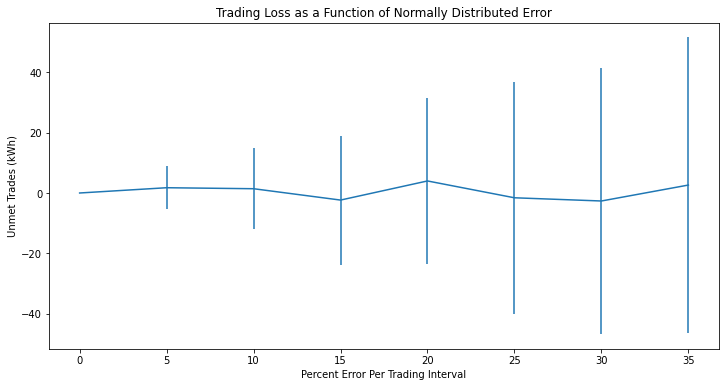

In [498]:
fig = plt.figure(figsize=(12,6))
plt.errorbar(np.multiply(perc_errors_norm,100), trading_loss.flatten(),yerr = total_production_std)
plt.xlabel('Percent Error Per Trading Interval')
plt.ylabel('Unmet Trades (kWh)')
plt.title('Trading Loss as a Function of Normally Distributed Error')

In [0]:
csv_out = pd.DataFrame({'avg total production': total_production_avg, 'total production std': total_production_std, 'unmet trades (kWh)': trading_loss}, index= perc_errors_norm)

In [0]:
csv_out.to_csv('/content/gdrive/My Drive/profiles/trading_loss.csv')